In [3]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [4]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() 
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:     
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() 
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df

In [5]:
sample_feature = reduce_mem_usage(pd.read_csv('data_for_tree.csv'))

Memory usage of dataframe is 62400128.00 MB
Memory usage after optimization is: 16600232.00 MB
Decreased by 73.4%


In [6]:
sample_feature.head()

,SaleID,name,model,brand,bodyType,fuelType,gearbox,power,kilometer,notRepairedDamage,...,used_time,city,brand_amount,brand_price_max,brand_price_median,brand_price_min,brand_price_sum,brand_price_std,brand_price_average,power_bin
0,0,736,30.0,6,1.0,0.0,0.0,60,12.5,0.0,...,4384.0,1.0,10216.0,59900.0,1800.0,13.0,36902172.0,4680.0,3612.0,5.0
1,1,2262,40.0,1,2.0,0.0,0.0,0,15.0,-,...,4756.0,4.0,13792.0,99900.0,6500.0,15.0,127916064.0,9368.0,9272.0,NaN
2,2,14874,115.0,15,1.0,0.0,0.0,163,12.5,0.0,...,4384.0,2.0,1458.0,45000.0,8496.0,100.0,14373814.0,5424.0,9848.0,16.0
3,3,71865,109.0,10,0.0,0.0,1.0,193,15.0,0.0,...,7124.0,NaN,14248.0,98000.0,5400.0,15.0,120700488.0,8992.0,8472.0,19.0
4,4,111080,110.0,5,1.0,0.0,0.0,68,5.0,0.0,...,1531.0,6.0,4664.0,31500.0,2300.0,20.0,15424120.0,3344.0,3306.0,6.0


In [7]:
continuous_feature_names = [x for x in sample_feature.columns if x not in ['price','brand','model','brand']]

In [8]:
sample_feature = sample_feature.dropna().replace('-', 0).reset_index(drop=True)
sample_feature['notRepairedDamage'] = sample_feature['notRepairedDamage'].astype(np.float32)
train = sample_feature[continuous_feature_names + ['price']]

train_X = train[continuous_feature_names]
train_y = train['price']

In [9]:
train_X.head()

,SaleID,name,bodyType,fuelType,gearbox,power,kilometer,notRepairedDamage,seller,offerType,...,used_time,city,brand_amount,brand_price_max,brand_price_median,brand_price_min,brand_price_sum,brand_price_std,brand_price_average,power_bin
0,0,736,1.0,0.0,0.0,60,12.5,0.0,0,0,...,4384.0,1.0,10216.0,59900.0,1800.0,13.0,36902172.0,4680.0,3612.0,5.0
1,2,14874,1.0,0.0,0.0,163,12.5,0.0,0,0,...,4384.0,2.0,1458.0,45000.0,8496.0,100.0,14373814.0,5424.0,9848.0,16.0
2,4,111080,1.0,0.0,0.0,68,5.0,0.0,0,0,...,1531.0,6.0,4664.0,31500.0,2300.0,20.0,15424120.0,3344.0,3306.0,6.0
3,5,137642,0.0,1.0,0.0,109,10.0,0.0,0,0,...,2482.0,3.0,14248.0,98000.0,5400.0,15.0,120700488.0,8992.0,8472.0,10.0
4,6,2402,0.0,0.0,1.0,150,15.0,0.0,0,0,...,6184.0,3.0,16736.0,99999.0,6000.0,12.0,142913696.0,8472.0,8536.0,14.0


In [10]:
from sklearn.linear_model import LinearRegression

In [11]:
model = LinearRegression(normalize=True)

In [12]:
model

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [14]:
model = model.fit(train_X, train_y)

In [15]:
model

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [16]:
'intercept:'+ str(model.intercept_)

sorted(dict(zip(continuous_feature_names, model.coef_)).items(), key=lambda x:x[1], reverse=True)

[('v_6', 3372669.643929724),
 ('v_8', 701432.2110340355),
 ('v_9', 169509.4271135992),
 ('v_7', 32757.631350658783),
 ('v_12', 23807.64952958383),
 ('v_3', 19739.21668955329),
 ('v_11', 13163.940983394585),
 ('v_13', 11963.464984653589),
 ('v_10', 3659.7579200214614),
 ('gearbox', 878.4816253884345),
 ('fuelType', 372.24870228828325),
 ('bodyType', 185.91755900288786),
 ('city', 46.982759554224465),
 ('power', 30.88299152156325),
 ('brand_price_median', 0.4612524846595706),
 ('brand_amount', 0.14337558626063468),
 ('brand_price_std', 0.13126146237472724),
 ('brand_price_max', 0.012643738651113092),
 ('used_time', 0.0006779416045813419),
 ('SaleID', 5.0161735988178466e-05),
 ('seller', 3.52377537637949e-06),
 ('train', -2.2351741790771484e-07),
 ('offerType', -1.207110472023487e-06),
 ('brand_price_sum', -1.96981165290243e-05),
 ('name', -0.00024808160266361805),
 ('brand_price_average', -0.22234169615518348),
 ('brand_price_min', -1.9643720816004875),
 ('power_bin', -56.46399500595334)

In [17]:
from matplotlib import pyplot as plt

In [18]:
subsample_index = np.random.randint(low=0, high=len(train_y), size=50)

In [19]:
subsample_index

array([51922, 32812, 26388, 60403,  3418, 60307, 77700, 58975, 23859,
       70442, 89430,   642, 58305, 73220,  8800, 61830, 76376, 21470,
       19224, 20896, 65968, 32209, 40796, 80143, 63550, 54886, 70601,
        1380, 71885, 63064, 39587, 68435, 20961, 15813, 67221, 30586,
       80108, 50111, 22439,   477, 76993, 61226, 58294, 15685,  2417,
       43241, 48746, 57754, 91043, 35712])

The predicted price is obvious different from true price


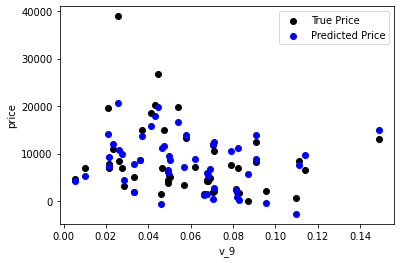

In [20]:
plt.scatter(train_X['v_9'][subsample_index], train_y[subsample_index], color='black')
plt.scatter(train_X['v_9'][subsample_index], model.predict(train_X.loc[subsample_index]), color='blue')
plt.xlabel('v_9')
plt.ylabel('price')
plt.legend(['True Price','Predicted Price'],loc='upper right')
print('The predicted price is obvious different from true price')
plt.show()

It is clear to see the price shows a typical exponential distribution


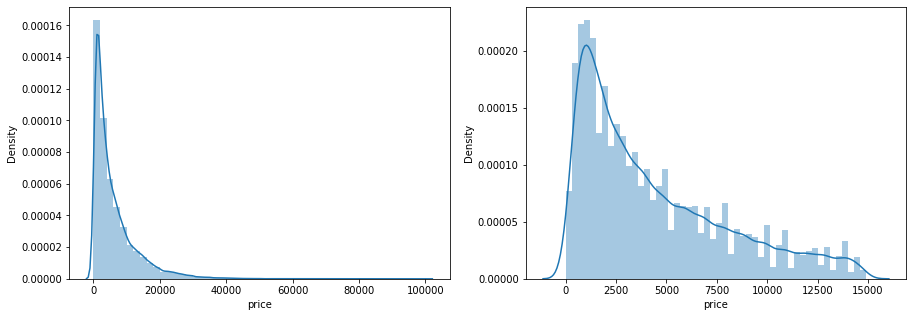

In [21]:
import seaborn as sns
print('It is clear to see the price shows a typical exponential distribution')
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.distplot(train_y)
plt.subplot(1,2,2)
sns.distplot(train_y[train_y < np.quantile(train_y, 0.9)])

In [22]:
train_y_ln = np.log(train_y + 1)

The transformed price seems like normal distribution


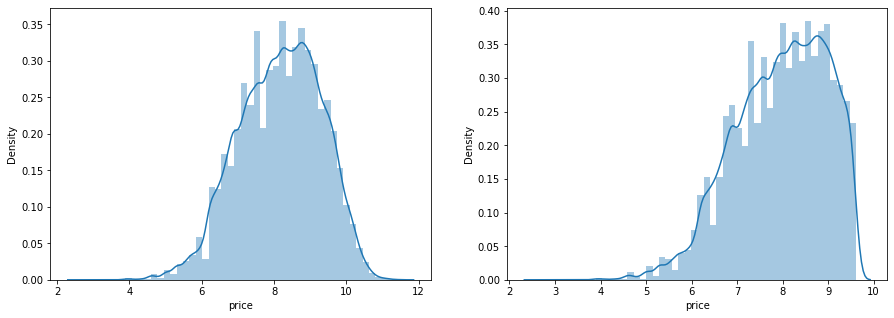

In [23]:
import seaborn as sns
print('The transformed price seems like normal distribution')
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.distplot(train_y_ln)
plt.subplot(1,2,2)
sns.distplot(train_y_ln[train_y_ln < np.quantile(train_y_ln, 0.9)])

In [24]:
model = model.fit(train_X, train_y_ln)

print('intercept:'+ str(model.intercept_))
sorted(dict(zip(continuous_feature_names, model.coef_)).items(), key=lambda x:x[1], reverse=True)

intercept:17.978210139692006


[('v_9', 8.39808221525217),
 ('v_5', 6.773461979845312),
 ('v_1', 1.4347582189090962),
 ('v_12', 1.0400143656144083),
 ('v_13', 0.9538992907451006),
 ('v_11', 0.8221681353390542),
 ('v_7', 0.8050255883635682),
 ('v_3', 0.4220297606285084),
 ('v_0', 0.02034615798005009),
 ('power_bin', 0.00902544439222797),
 ('gearbox', 0.007465440397442843),
 ('fuelType', 0.006780222729121989),
 ('bodyType', 0.004546057655215402),
 ('power', 0.0006839144329483858),
 ('brand_price_min', 2.793032457556986e-05),
 ('brand_price_std', 2.5048185087837943e-06),
 ('brand_price_median', 2.4342171756623112e-06),
 ('brand_amount', 1.99888493420167e-06),
 ('brand_price_max', 1.3851484742584517e-07),
 ('SaleID', 2.0534796927641105e-08),
 ('seller', 1.4175149942730059e-10),
 ('brand_price_sum', 7.599160264161384e-11),
 ('train', 3.836930773104541e-12),
 ('offerType', -6.09565731224393e-11),
 ('name', -7.041018580462589e-08),
 ('brand_price_average', -1.124232090478459e-06),
 ('used_time', -4.024858559419073e-06),
 (

The predicted price seems normal after np.log transforming


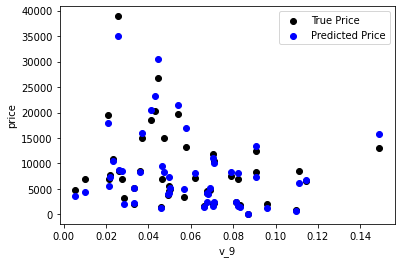

In [25]:
plt.scatter(train_X['v_9'][subsample_index], train_y[subsample_index], color='black')
plt.scatter(train_X['v_9'][subsample_index], np.exp(model.predict(train_X.loc[subsample_index])), color='blue')
plt.xlabel('v_9')
plt.ylabel('price')
plt.legend(['True Price','Predicted Price'],loc='upper right')
print('The predicted price seems normal after np.log transforming')
plt.show()

In [26]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error,  make_scorer

In [27]:
def log_transfer(func):
    def wrapper(y, yhat):
        result = func(np.log(y), np.nan_to_num(np.log(yhat)))
        return result
    return wrapper

In [28]:
scores = cross_val_score(model, X=train_X, y=train_y, verbose=1, cv = 5, scoring=make_scorer(log_transfer(mean_absolute_error)))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished


In [29]:
print('AVG:', np.mean(scores))

AVG: 1.368495021683191


In [30]:
scores = cross_val_score(model, X=train_X, y=train_y_ln, verbose=1, cv = 5, scoring=make_scorer(mean_absolute_error))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.4s finished


In [31]:
print('AVG:', np.mean(scores))

AVG: 0.19331244235782008


In [32]:
scores = pd.DataFrame(scores.reshape(1,-1))
scores.columns = ['cv' + str(x) for x in range(1, 6)]
scores.index = ['MAE']
scores

,cv1,cv2,cv3,cv4,cv5
MAE,0.190851,0.193835,0.194196,0.191812,0.195868


In [33]:
import datetime

In [34]:
sample_feature = sample_feature.reset_index(drop=True)

In [35]:
split_point = len(sample_feature) // 5 * 4


In [36]:
train = sample_feature.loc[:split_point].dropna()
val = sample_feature.loc[split_point:].dropna()

train_X = train[continuous_feature_names]
train_y_ln = np.log(train['price'] + 1)
val_X = val[continuous_feature_names]
val_y_ln = np.log(val['price'] + 1)

In [37]:
model = model.fit(train_X, train_y_ln)

In [38]:
mean_absolute_error(val_y_ln, model.predict(val_X))

0.19588884366235554

In [39]:
from sklearn.model_selection import learning_curve, validation_curve
? learning_curve

In [40]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,n_jobs=1, train_size=np.linspace(.1, 1.0, 5 )):  
    plt.figure()  
    plt.title(title)  
    if ylim is not None:  
        plt.ylim(*ylim)  
    plt.xlabel('Training example')  
    plt.ylabel('score')  
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_size, scoring = make_scorer(mean_absolute_error))  
    train_scores_mean = np.mean(train_scores, axis=1)  
    train_scores_std = np.std(train_scores, axis=1)  
    test_scores_mean = np.mean(test_scores, axis=1)  
    test_scores_std = np.std(test_scores, axis=1)  
    plt.grid()#区域  
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,  
                     train_scores_mean + train_scores_std, alpha=0.1,  
                     color="r")  
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,  
                     test_scores_mean + test_scores_std, alpha=0.1,  
                     color="g")  
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r',  
             label="Training score")  
    plt.plot(train_sizes, test_scores_mean,'o-',color="g",  
             label="Cross-validation score")  
    plt.legend(loc="best")  
    return plt  

<module 'matplotlib.pyplot' from '/anaconda/envs/azureml_py36/lib/python3.6/site-packages/matplotlib/pyplot.py'>

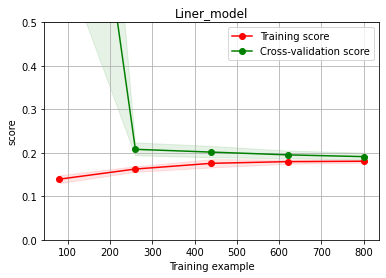

In [41]:
plot_learning_curve(LinearRegression(), 'Liner_model', train_X[:1000], train_y_ln[:1000], ylim=(0.0, 0.5), cv=5, n_jobs=1)  

In [42]:
train = sample_feature[continuous_feature_names + ['price']].dropna()

train_X = train[continuous_feature_names]
train_y = train['price']
train_y_ln = np.log(train_y + 1)

In [43]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

In [44]:
models = [LinearRegression(),
          Ridge(),
          Lasso()]

In [45]:
result = dict()
for model in models:
    model_name = str(model).split('(')[0]
    scores = cross_val_score(model, X=train_X, y=train_y_ln, verbose=0, cv = 5, scoring=make_scorer(mean_absolute_error))
    result[model_name] = scores
    print(model_name + ' is finished')

LinearRegression is finished
Ridge is finished
Lasso is finished


In [46]:
result = pd.DataFrame(result)
result.index = ['cv' + str(x) for x in range(1, 6)]
result

,LinearRegression,Ridge,Lasso
cv1,0.190851,0.194948,0.383809
cv2,0.193835,0.197714,0.382178
cv3,0.194196,0.198252,0.383611
cv4,0.191812,0.195694,0.380331
cv5,0.195868,0.199817,0.383782


intercept:17.97821013969179


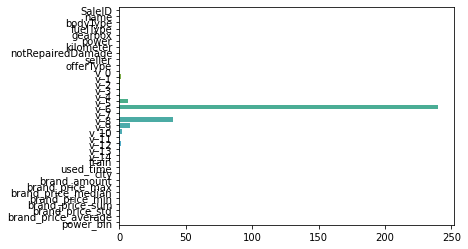

In [47]:
model = LinearRegression().fit(train_X, train_y_ln)
print('intercept:'+ str(model.intercept_))
sns.barplot(abs(model.coef_), continuous_feature_names)

intercept:8.761375614245509


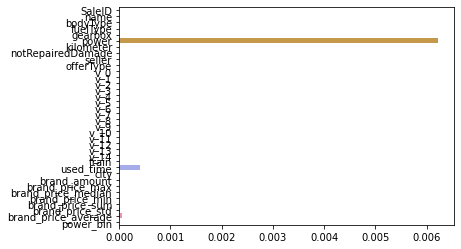

In [48]:
model = Lasso().fit(train_X, train_y_ln)
print('intercept:'+ str(model.intercept_))
sns.barplot(abs(model.coef_), continuous_feature_names)

In [49]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from xgboost.sklearn import XGBRegressor
from lightgbm.sklearn import LGBMRegressor

In [50]:
models = [LinearRegression(),
          DecisionTreeRegressor(),
          RandomForestRegressor(),
          GradientBoostingRegressor(),
          MLPRegressor(solver='lbfgs', max_iter=100), 
          XGBRegressor(n_estimators = 100, objective='reg:squarederror'), 
          LGBMRegressor(n_estimators = 100)]

In [51]:
result = dict()
for model in models:
    model_name = str(model).split('(')[0]
    scores = cross_val_score(model, X=train_X, y=train_y_ln, verbose=0, cv = 5, scoring=make_scorer(mean_absolute_error))
    result[model_name] = scores
    print(model_name + ' is finished')

LinearRegression is finished
DecisionTreeRegressor is finished
RandomForestRegressor is finished
GradientBoostingRegressor is finished
MLPRegressor is finished
XGBRegressor is finished
LGBMRegressor is finished


In [52]:
result = pd.DataFrame(result)
result.index = ['cv' + str(x) for x in range(1, 6)]
result

,LinearRegression,DecisionTreeRegressor,RandomForestRegressor,GradientBoostingRegressor,MLPRegressor,XGBRegressor,LGBMRegressor
cv1,0.190851,0.198633,0.133028,0.169333,862.751230,0.169845,0.141224
cv2,0.193835,0.193157,0.134395,0.172461,344.487597,0.171185,0.145021
cv3,0.194196,0.189671,0.133586,0.170967,323.759715,0.171709,0.143510
cv4,0.191812,0.189852,0.132533,0.168597,225.612596,0.168846,0.142374
cv5,0.195868,0.205469,0.137349,0.173282,94.571730,0.173618,0.145046


In [53]:
objective = ['regression', 'regression_l1', 'mape', 'huber', 'fair']

num_leaves = [3,5,10,15,20,40, 55]
max_depth = [3,5,10,15,20,40, 55]
bagging_fraction = []
feature_fraction = []
drop_rate = []


In [54]:
best_obj = dict()
for obj in objective:
    model = LGBMRegressor(objective=obj)
    score = np.mean(cross_val_score(model, X=train_X, y=train_y_ln, verbose=0, cv = 5, scoring=make_scorer(mean_absolute_error)))
    best_obj[obj] = score
    
best_leaves = dict()
for leaves in num_leaves:
    model = LGBMRegressor(objective=min(best_obj.items(), key=lambda x:x[1])[0], num_leaves=leaves)
    score = np.mean(cross_val_score(model, X=train_X, y=train_y_ln, verbose=0, cv = 5, scoring=make_scorer(mean_absolute_error)))
    best_leaves[leaves] = score
    
best_depth = dict()
for depth in max_depth:
    model = LGBMRegressor(objective=min(best_obj.items(), key=lambda x:x[1])[0],
                          num_leaves=min(best_leaves.items(), key=lambda x:x[1])[0],
                          max_depth=depth)
    score = np.mean(cross_val_score(model, X=train_X, y=train_y_ln, verbose=0, cv = 5, scoring=make_scorer(mean_absolute_error)))
    best_depth[depth] = score

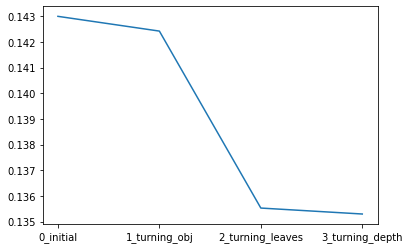

In [55]:
sns.lineplot(x=['0_initial','1_turning_obj','2_turning_leaves','3_turning_depth'], y=[0.143 ,min(best_obj.values()), min(best_leaves.values()), min(best_depth.values())])

In [56]:
from sklearn.model_selection import GridSearchCV

In [ ]:
parameters = {'objective': objective , 'num_leaves': num_leaves, 'max_depth': max_depth}
model = LGBMRegressor()
clf = GridSearchCV(model, parameters, cv=5)
clf = clf.fit(train_X, train_y)

In [ ]:
clf.best_params_

In [ ]:
model = LGBMRegressor(objective='regression',
                          num_leaves=55,
                          max_depth=15)

In [ ]:
np.mean(cross_val_score(model, X=train_X, y=train_y_ln, verbose=0, cv = 5, scoring=make_scorer(mean_absolute_error)))

In [ ]:
from bayes_opt import BayesianOptimization

In [ ]:
def rf_cv(num_leaves, max_depth, subsample, min_child_samples):
    val = cross_val_score(
        LGBMRegressor(objective = 'regression_l1',
            num_leaves=int(num_leaves),
            max_depth=int(max_depth),
            subsample = subsample,
            min_child_samples = int(min_child_samples)
        ),
        X=train_X, y=train_y_ln, verbose=0, cv = 5, scoring=make_scorer(mean_absolute_error)
    ).mean()
    return 1 - val

In [ ]:
rf_bo = BayesianOptimization(
    rf_cv,
    {
    'num_leaves': (2, 100),
    'max_depth': (2, 100),
    'subsample': (0.1, 1),
    'min_child_samples' : (2, 100)
    }
)

In [ ]:
rf_bo.maximize()

In [ ]:
1 - rf_bo.max['target']

In [ ]:
plt.figure(figsize=(13,5))
sns.lineplot(x=['0_origin','1_log_transfer','2_L1_&_L2','3_change_model','4_parameter_turning'], y=[1.36 ,0.19, 0.19, 0.14, 0.13])